In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import copy
# from lmphoton.simulation import current_simulation as sim
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation 

import sys
sys.path.append("../")

# SPPD optical elements
from src.sppd_clm_optics import SPPDCLMOPTICS_LAMBDA_AB

# PMIC drivers
from src.pikeriver_pmic import PMIC

# Calibration and control
from src.sppd_clm import CONTROLLER
from src.laser_control.pid import pid as PID

plt.style.use("plot_style.mplstyle")
warnings.filterwarnings("ignore")

In [2]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([1.30150695e-06, 1.30266500e-06, 1.30381006e-06, 1.30500515e-06,
       1.30605274e-06, 1.30707336e-06, 1.30832819e-06, 1.30946877e-06,
       1.31060618e-06, 1.31173168e-06, 1.31281666e-06, 1.31414471e-06,
       1.31525203e-06, 1.31619448e-06, 1.31740494e-06, 1.31861709e-06])

wavelength_fabrication_easy = target_grid_array

In [3]:
dfb_backside_temperature = 273+36
ebmux_backside_temperature = 273+45

_sppd_clm_optics = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.146,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication,
  dfb_backside_temperature= dfb_backside_temperature,
  ebmux_backside_temperature= ebmux_backside_temperature,
  bw_lambda = 0.2e-9,
  sppd_eb_atten_dB = 1.72,
  ebmux_tec_bool=False,
  name = "SPPDCLMOPTICS",
  no_mux = 1
  )

print("Wavelength fabrication")
print(_sppd_clm_optics._sppd_clm_pic._lambda_array*1e9)
print("\nCase temperature")
print(_sppd_clm_optics._temperature-273)
current_array = np.ones(16) * 0.146
_sppd_clm_optics.update(tc = dfb_backside_temperature, i_array=current_array)

_laser_array_sppd_clm = _sppd_clm_optics._lambda_array

print("\nWavelength after update")
print(_sppd_clm_optics._lambda_array*1e9)
print("\nTarget wavelength ideal")
print(_sppd_clm_optics._target_grid_array*1e9)
print("\n Current array")
print(_sppd_clm_optics._sppd_clm_pic_mpd_current_array)


Wavelength fabrication
[1301.50695 1302.665   1303.81006 1305.00515 1306.05274 1307.07336
 1308.32819 1309.46877 1310.60618 1311.73168 1312.81666 1314.14471
 1315.25203 1316.19448 1317.40494 1318.61709]

Case temperature
36

Wavelength after update
[1301.50695 1302.665   1303.81006 1305.00515 1306.05274 1307.07336
 1308.32819 1309.46877 1310.60618 1311.73168 1312.81666 1314.14471
 1315.25203 1316.19448 1317.40494 1318.61709]

Target wavelength ideal
[1301.47 1302.6  1303.73 1304.87 1306.01 1307.14 1308.28 1309.43 1310.57
 1311.72 1312.87 1314.02 1315.17 1316.33 1317.48 1318.64]

 Current array
[0.0003514 0.0003514 0.0003514 0.0003514 0.0003514 0.0003514 0.0003514
 0.0003514 0.0003514 0.0003514 0.0003514 0.0003514 0.0003514 0.0003514
 0.0003514 0.0003514]


In [4]:
_pk_pmic = PMIC()

dt = 100e-3
_pid_tec = pid_tec = PID(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3)
_pid_idrive = [PID(kp=1/1000, ki=1/1000, kd=1/1000, dt=dt, umax = 1024, umin=-1024) for __ in range(len(wavelength_fabrication))]

In [5]:
controller = CONTROLLER(
  sppd_clm_optics = _sppd_clm_optics,
  pmic = _pk_pmic,
  drive_current_array = current_array,
  pid_tec = _pid_tec,
  pid_idrive = _pid_idrive,
  dt = dt,
)


controller._tend = 100
controller._tdither = 40.0
controller._tagg_1 = 50.0
controller._tagg_2 = 75.0
controller._agg_1_amp = 1
controller._agg_2_amp = 1

In [6]:
start = time.time()
controller.calibrate(tc=dfb_backside_temperature,
            temperature_array = np.linspace(30, 65, 201)+273, 
            drive_current_array= np.linspace(0.1, 0.2, 101),
            power_wavelength_calibration=True,
            tec_temperature_tuning=True,
            drive_current_tuning=False,
            )
print(f"Calibration time: {time.time()-start:0.2f} s")

Calibration time: 26.05 s


In [7]:
nom_temp_array = controller._nominal_temperature_array
tec_set_point_temperature = controller._tec_set_point_temperature
mux_current_array = controller._pmic_adc_enablence_mux_mpd_current_array
peak_current_array = controller._pmic_adc_enablence_mux_mpd_peak_current_array
output_power_array = controller._enablence_output_power_array
output_lambda_array = controller._lambda_array
current_array = controller._drive_current_array
cal_temperature_array = controller._temperature_array
drive_current_array = controller._pmic._dac_laser_drive_current_array
laser_junction_temperature_array = controller._laser_junction_temperature_array

Laser TEC temp 0: 47.50 C, Laser Junction temp 0: 71.62 C, Enablence MPD current 0: 0.00, Pout 0: 0.00 mW, Lambda 0: 0.00 nm, Drive current 0: 132.85 mA
Laser TEC temp 1: 47.50 C, Laser Junction temp 1: 71.99 C, Enablence MPD current 1: 0.00, Pout 1: 0.00 mW, Lambda 1: 0.00 nm, Drive current 1: 136.99 mA
Laser TEC temp 2: 47.50 C, Laser Junction temp 2: 72.12 C, Enablence MPD current 2: 0.00, Pout 2: 0.00 mW, Lambda 2: 0.00 nm, Drive current 2: 135.62 mA
Laser TEC temp 3: 47.50 C, Laser Junction temp 3: 72.21 C, Enablence MPD current 3: 0.00, Pout 3: 0.00 mW, Lambda 3: 0.00 nm, Drive current 3: 134.94 mA
Laser TEC temp 4: 47.50 C, Laser Junction temp 4: 72.32 C, Enablence MPD current 4: 0.00, Pout 4: 0.00 mW, Lambda 4: 0.00 nm, Drive current 4: 135.73 mA
Laser TEC temp 5: 47.50 C, Laser Junction temp 5: 72.39 C, Enablence MPD current 5: 0.00, Pout 5: 0.00 mW, Lambda 5: 0.00 nm, Drive current 5: 136.79 mA
Laser TEC temp 6: 47.50 C, Laser Junction temp 6: 72.35 C, Enablence MPD current 6

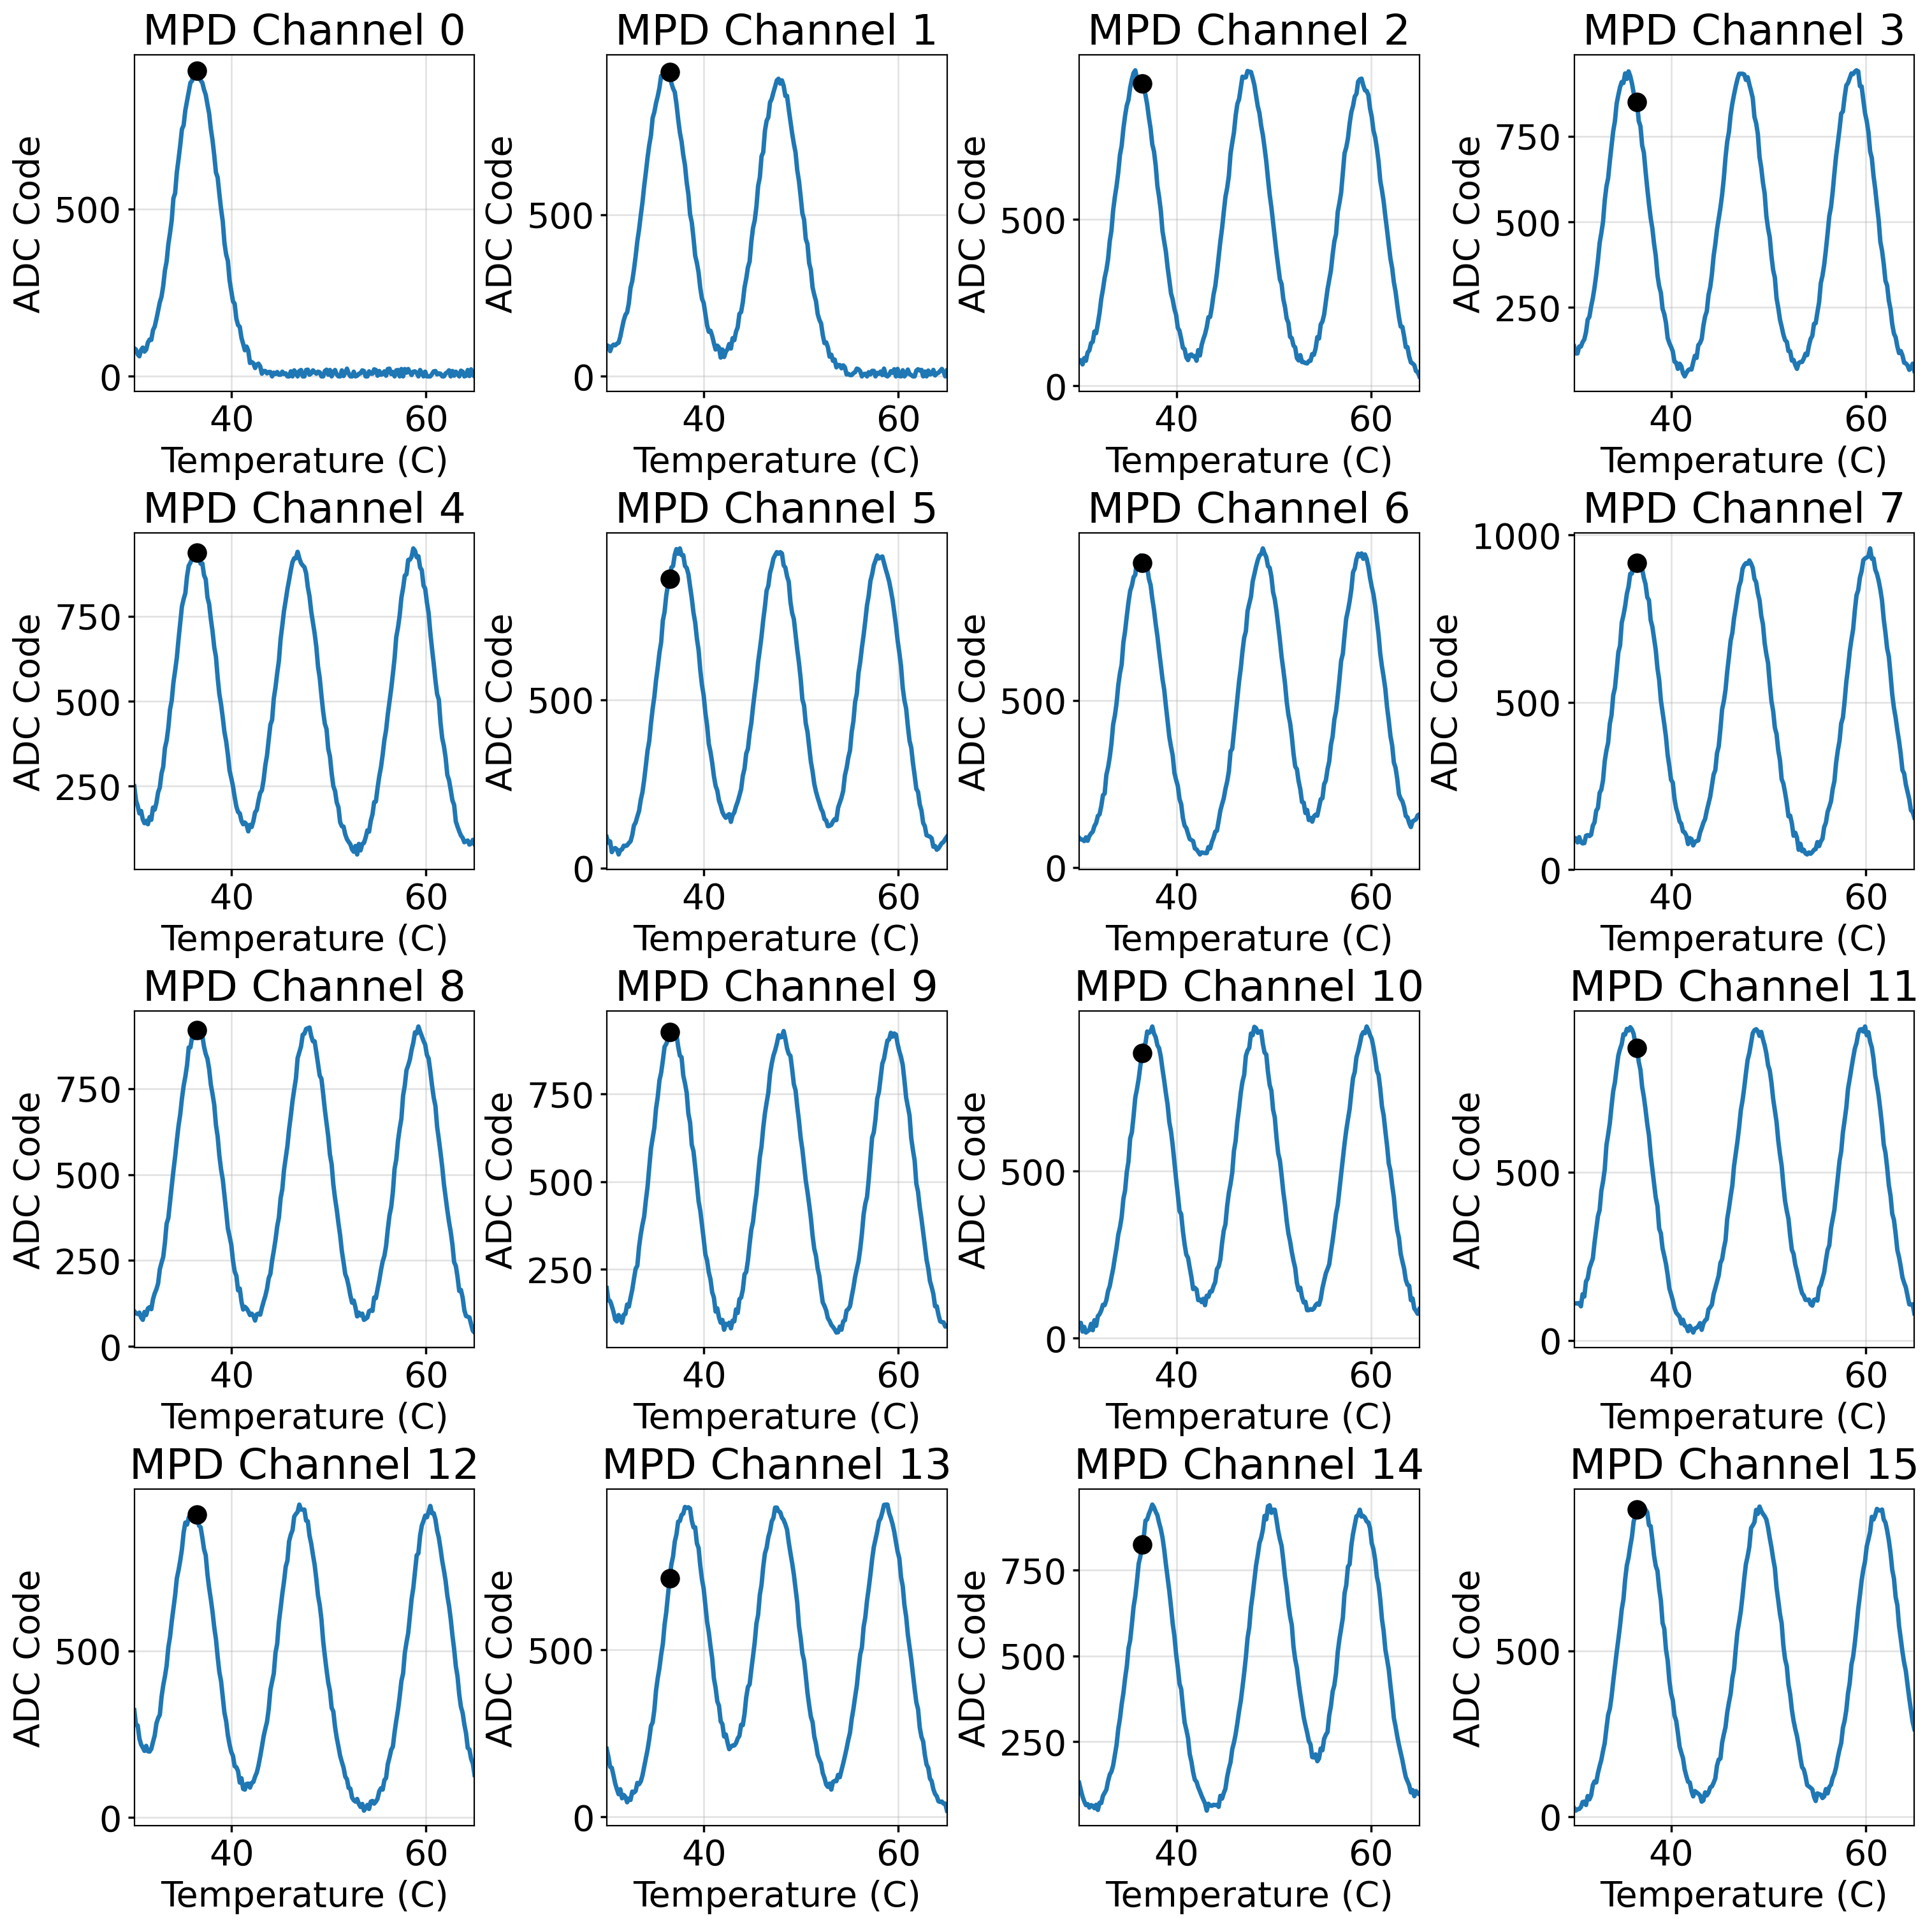

In [8]:
for idd_laser in range(16):
  print(f"Laser TEC temp {idd_laser}: {nom_temp_array[idd_laser]-273:0.2f} C, Laser Junction temp {idd_laser}: {laser_junction_temperature_array[idd_laser]-273:0.2f} C, Enablence MPD current {idd_laser}: {peak_current_array[idd_laser]:0.2f}, Pout {idd_laser}: {output_power_array[idd_laser]*1e3:0.2f} mW, Lambda {idd_laser}: {output_lambda_array[idd_laser]*1e9:0.2f} nm, Drive current {idd_laser}: {drive_current_array[idd_laser]*1e3:0.2f} mA")
print(f"TEC set point temperature: {tec_set_point_temperature-273:0.2f} C")

# Plot calibration per MUX channel (columns) and temperature (rows)
n_mpd_channels = len(target_grid_array)
# Set font size small
plt.rc('font', size=6)
fig, ax = plt.subplots(int(np.sqrt(n_mpd_channels)), int(np.sqrt(n_mpd_channels)), figsize=(15, 15))
for idd_mpd_channel in range(n_mpd_channels):
  _ax = ax[int(idd_mpd_channel/np.sqrt(n_mpd_channels)), int(idd_mpd_channel%np.sqrt(n_mpd_channels))]
  _ax.plot(cal_temperature_array-273, mux_current_array[:, idd_mpd_channel])
  idd_tec_temp = np.argmin(np.abs(cal_temperature_array - tec_set_point_temperature))
  _ax.plot(tec_set_point_temperature-273, mux_current_array[idd_tec_temp, idd_mpd_channel], 'o', color='k')
  _ax.set_xlim([30,65])
  _ax.set_xlabel("Temperature (C)")
  _ax.set_ylabel("ADC Code")
  _ax.set_title(f"MPD Channel {idd_mpd_channel}")

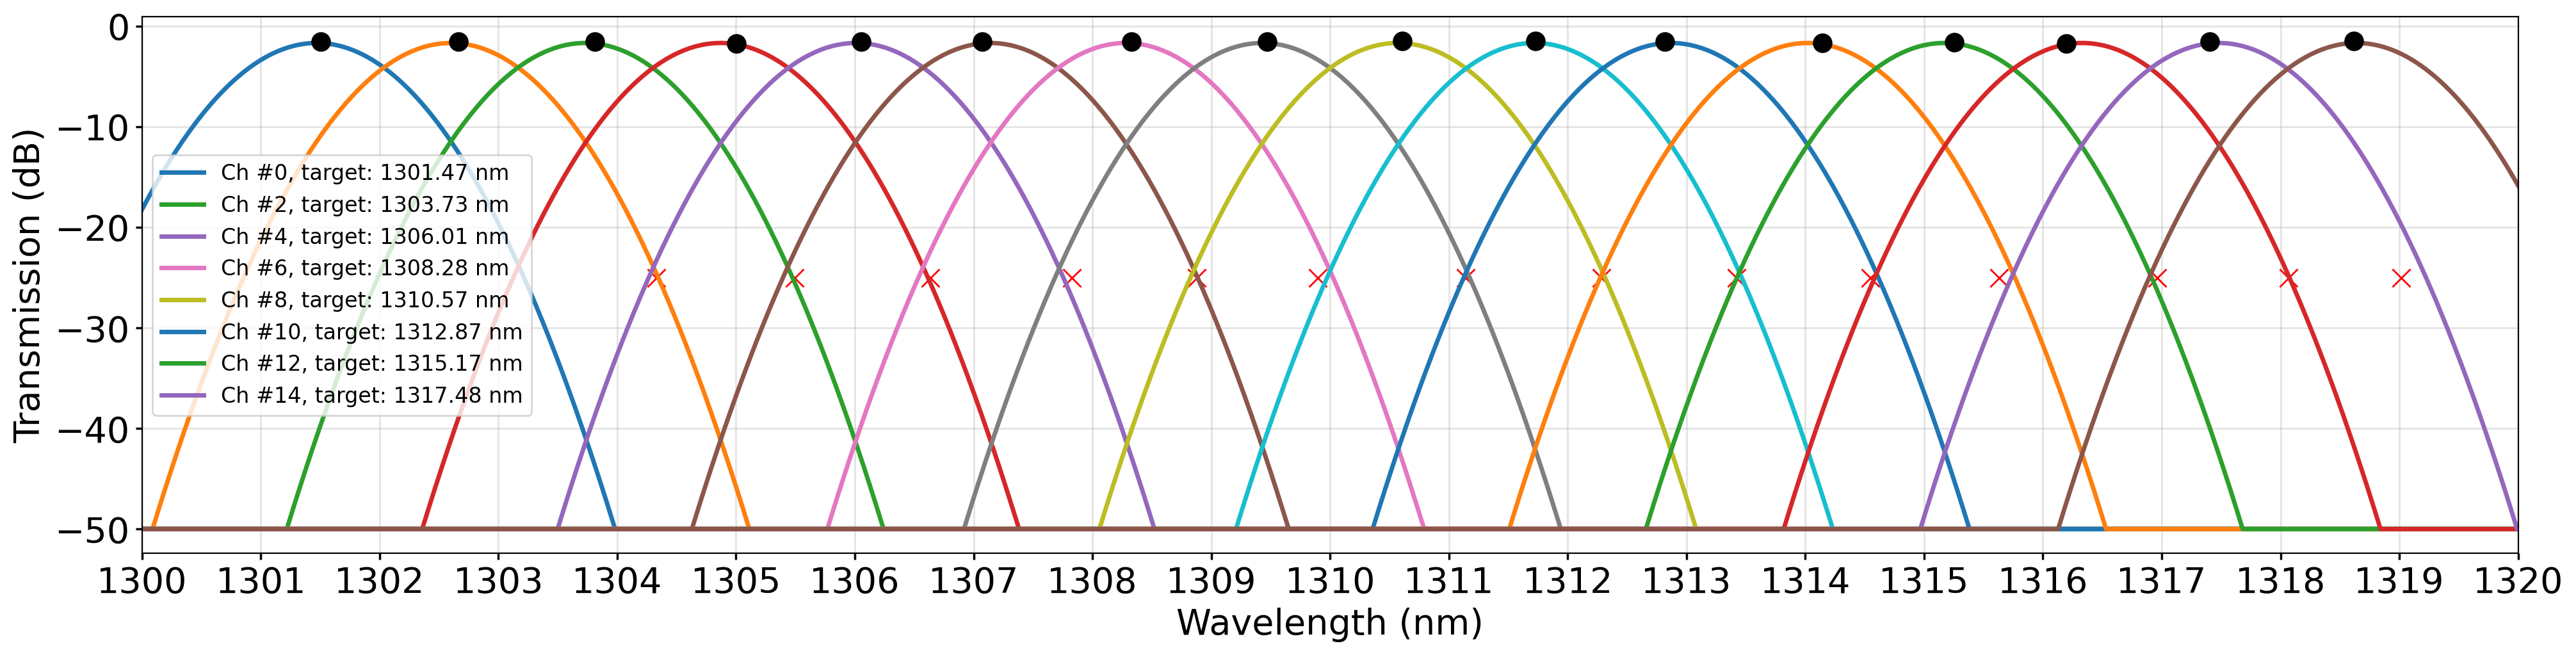

In [9]:
_enablence_mux = _sppd_clm_optics._ebmux

wavelength_fabrication_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - wavelength_fabrication[idd_target])) for idd_target in range(len(target_grid_array))]
wavelength_output_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - output_lambda_array[idd_target])) for idd_target in range(len(target_grid_array))]
wavelength_clm_standalone = _sppd_clm_optics._lambda_array
wavelength_clm_standalone_arg = [np.argmin(np.abs(_enablence_mux.lambda_sweep - wavelength_clm_standalone[idd_target])) for idd_target in range(len(target_grid_array))]

plt.figure(figsize=(20,5))
for idd_target in range(len(target_grid_array)):
  if idd_target%2 == 0:
    plt.plot(_enablence_mux.lambda_sweep*1e9, 10*np.log10(_enablence_mux.ebmux_tf_array_list[idd_target,:]), label="Ch #{:0.0f}, target: {:.2f} nm".format(idd_target, target_grid_array[idd_target]*1e9)) 
  else:
    plt.plot(_enablence_mux.lambda_sweep*1e9, 10*np.log10(_enablence_mux.ebmux_tf_array_list[idd_target,:])) 

  plt.plot(wavelength_fabrication[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_fabrication_arg[idd_target]]), "o", color='k')
  plt.plot(output_lambda_array[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_output_arg[idd_target]]), "^", color='g')
  plt.plot(wavelength_clm_standalone[idd_target]*1e9, 10*np.log10(_enablence_mux.enablence_mux_tf_array_list[idd_target,wavelength_clm_standalone_arg[idd_target]]), "x", color='r')
plt.xlim([1300, 1320])
plt.xticks(np.arange(1300, 1321, 1))
plt.legend(fontsize=12)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (dB)")
plt.grid(True)

In [10]:
start = time.time()
controller._tec_set_point_temperature = controller._tec_set_point_temperature
controller.control(lin_sweep_range=0.2, output_power_clamp_bool = True, output_power_clamp = 0.044, aggressor_duration=25.0)

print(f"Control time: {time.time()-start:0.2f} s")

Control time: 50.75 s


In [11]:
t = controller._t
laser_drive_current_array = controller._drive_current_array_time_step
laser_output_power_array = controller._enablence_output_power_array_time_step
laser_wavelength_array = controller._enablence_output_lambda_array_time_step
laser_mpd_current_array = controller._pmic_adc_clm_pic_mpd_code_time_step
sppd_pout_array = controller._sppd_pout_array_time_step
laser_mux_mpd_current_array = controller._pmic_adc_enablence_mux_mpd_code_time_step
laser_junction_temperature_array = controller._sppd_laser_junction_temperature_array_time_step
q = controller._q
i_tec = controller._i_tec
v_tec = controller._v_tec
t_case = controller._t_case
tec_th = controller._tec_th

wavelength_error = copy.deepcopy(laser_wavelength_array)
for idd_laser in range(16):
  wavelength_error[idd_laser,:] = laser_wavelength_array[idd_laser,:] - target_grid_array[idd_laser]

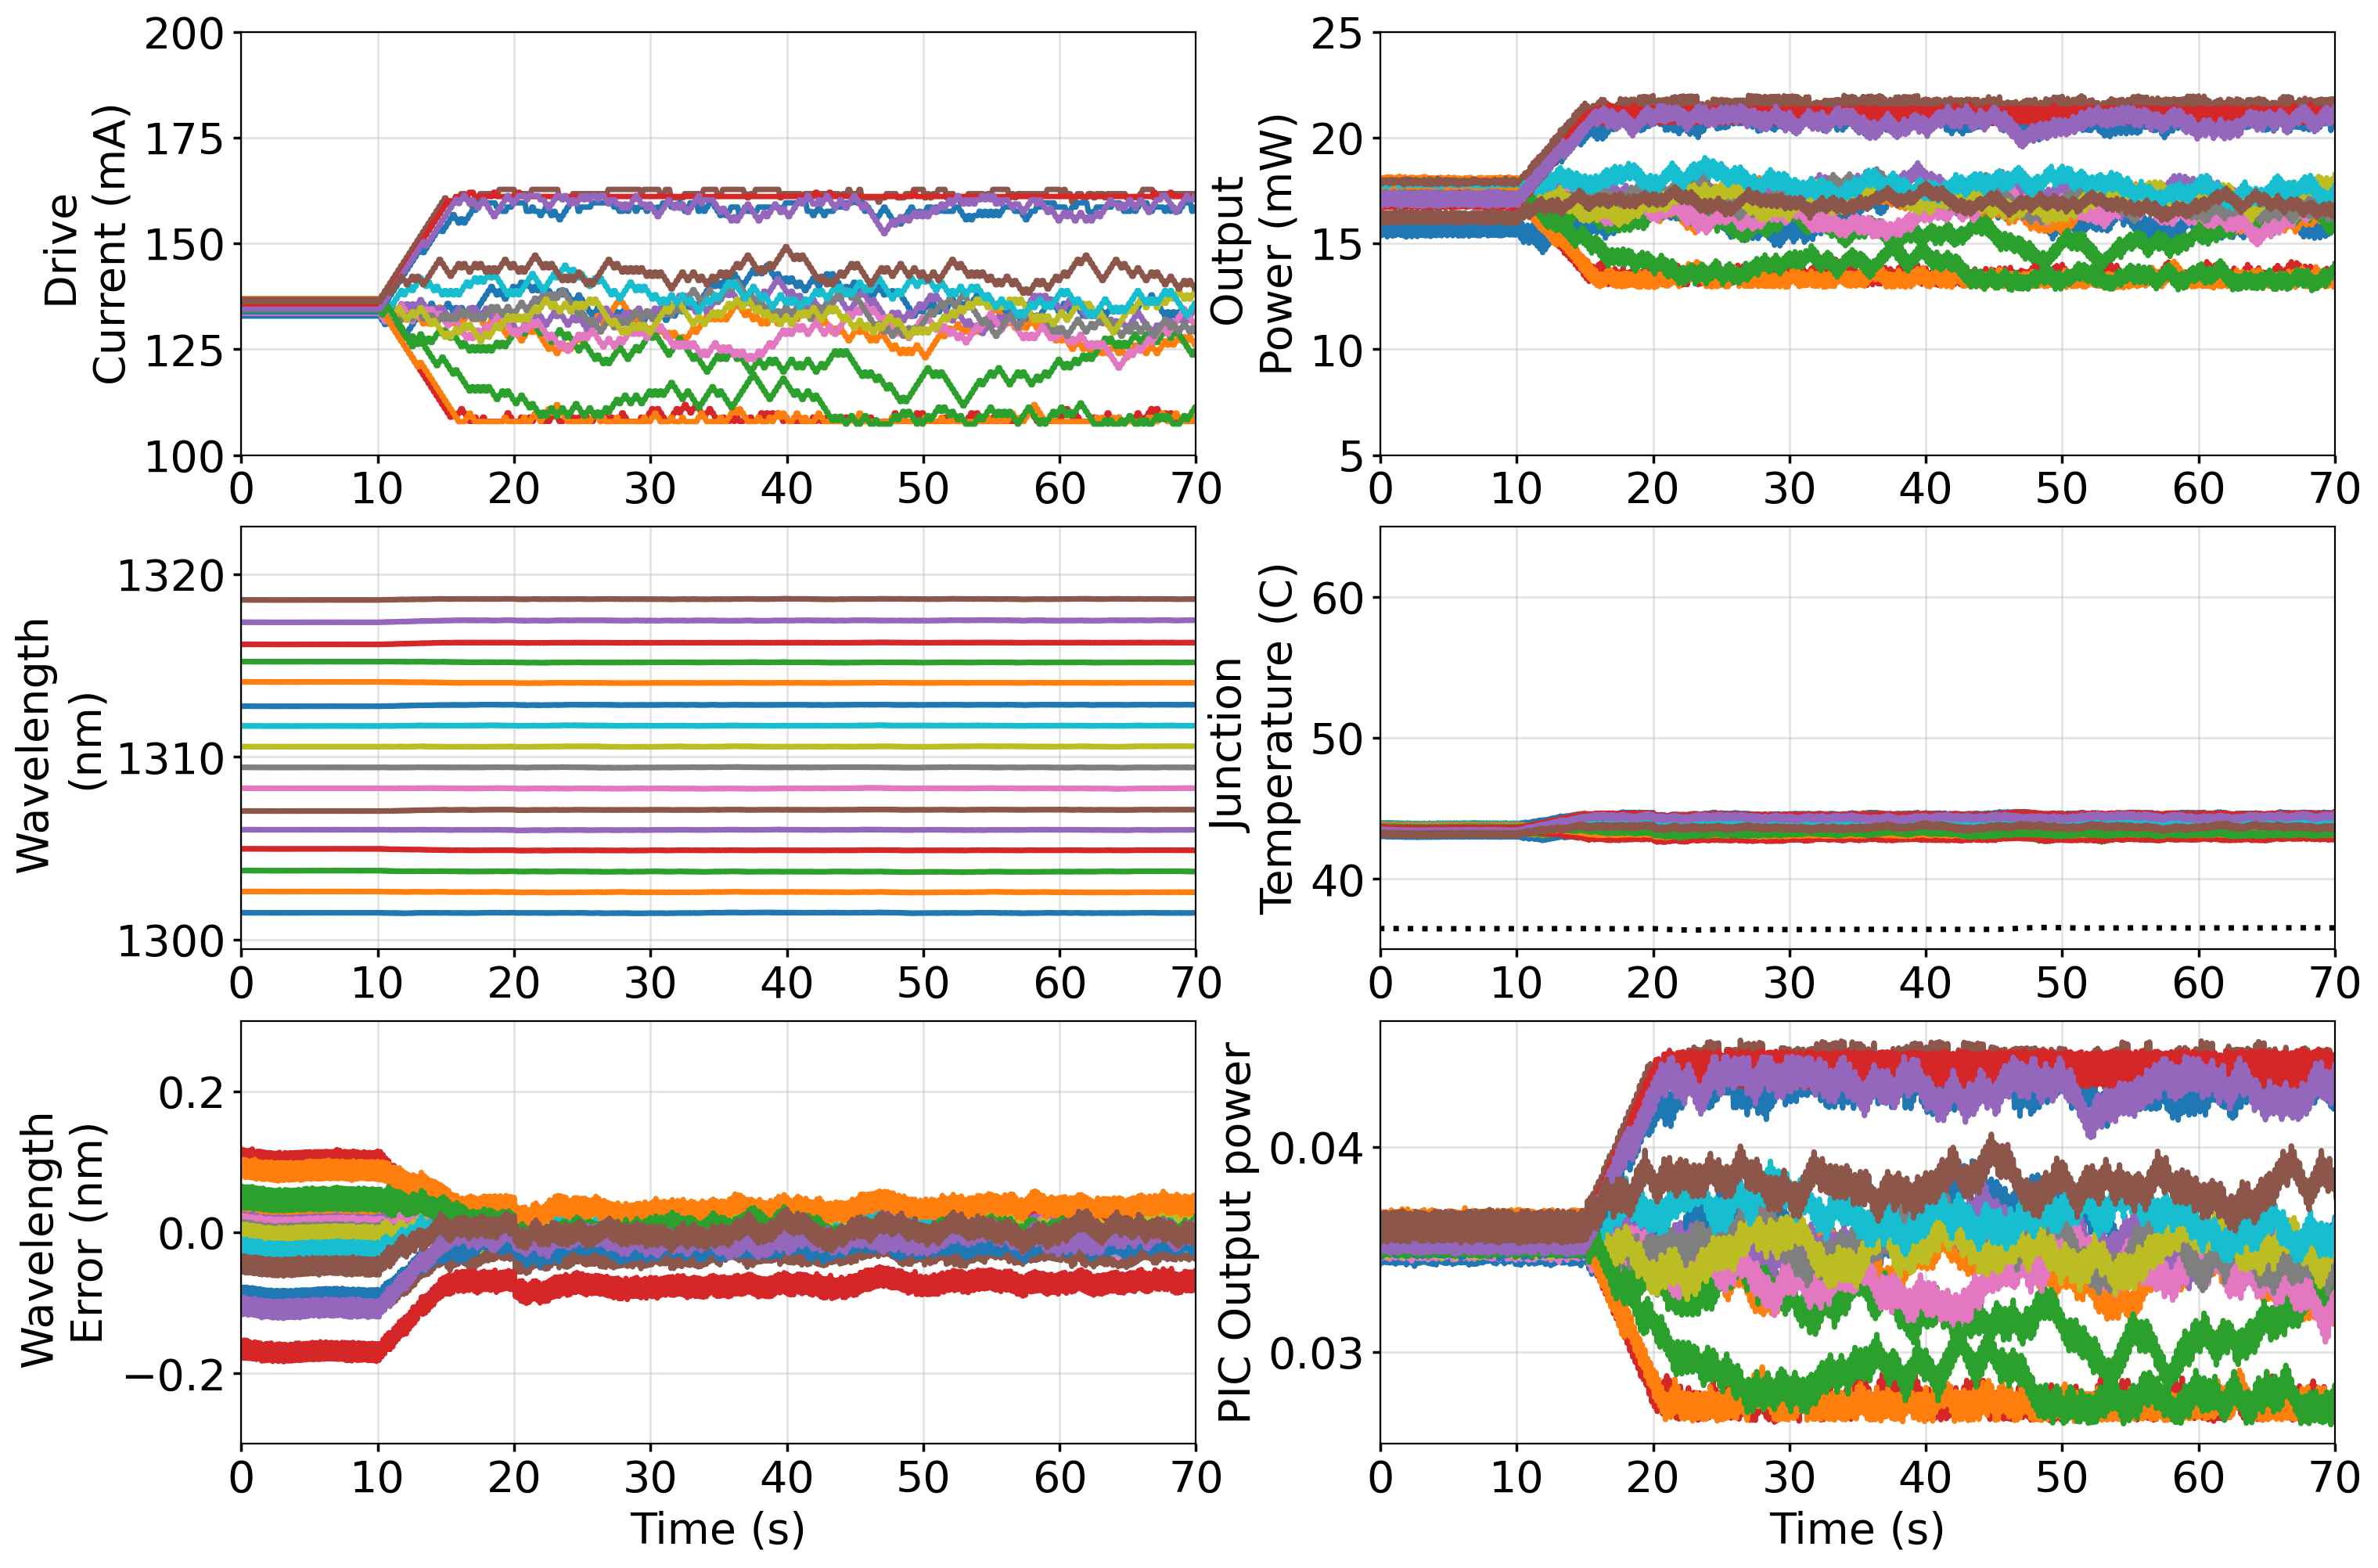

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
xlim = [0,70]
ax[0, 0].plot(t-30, laser_drive_current_array.T*1e3)
ax[0, 0].set_ylabel("Drive \nCurrent (mA)")
ax[0, 0].set_ylim([100, 200])
ax[0, 1].plot(t-30, laser_output_power_array.T*1e3)
ax[0, 1].set_ylim([5, 25])
ax[0, 1].set_ylabel("Output \nPower (mW)")
ax[1, 0].plot(t-30, laser_wavelength_array.T*1e9)
ax[1, 0].set_ylabel("Wavelength \n(nm)")
ax[1, 1].plot(t-30, t_case-273, linestyle = ':',color = 'k')
ax[1, 1].plot(t-30, laser_junction_temperature_array.T-273)
ax[1,1].set_ylim([35, 65])
ax[1, 1].set_ylabel("Junction \nTemperature (C)")
ax[2, 0].plot(t-30, wavelength_error.T*1e9)
ax[2, 0].set_xlabel("Time (s)")
ax[2, 0].set_ylabel("Wavelength \nError (nm)")
ax[2, 0].set_ylim(-1, 1)
ax[2,0].set_ylim([-0.3, 0.3])
ax[2, 1].plot(t-25, sppd_pout_array.T)
ax[2, 1].set_xlabel("Time (s)")
ax[2, 1].set_ylabel("PIC Output power")
for i in range(3):
  for j in range(2):
    ax[i,j].set_xlim(xlim)
plt.tight_layout()

In [13]:
np.shape(laser_drive_current_array.T[300:300+100,0])

(100,)

In [14]:
t_reduced = []

laser_drive_current_array_reduced = []
wavelength_error_reduced = []
output_power_array_reduced = []
temperature_aggressor_reduced = []
tec_th_reduced = []
tec_v_reduced = []
tec_i_reduced = []

for i in range(len(t)):
  if i>299:
    if i%10 == 0:
      t_reduced.append(t[i])
      laser_drive_current_array_reduced.append(laser_drive_current_array.T[i].tolist())
      wavelength_error_reduced.append(wavelength_error.T[i].tolist())
      output_power_array_reduced.append(laser_output_power_array.T[i].tolist())
      temperature_aggressor_reduced.append(t_case[i]-273.15)
      tec_th_reduced.append(tec_th[i]-273.15)
      tec_v_reduced.append(v_tec[i])
      tec_i_reduced.append(i_tec[i])
      
t_reduced = np.array(t_reduced)
laser_drive_current_array_reduced = np.array(laser_drive_current_array_reduced)
wavelength_error_reduced = np.array(wavelength_error_reduced)
output_power_array_reduced = np.array(output_power_array_reduced)
temperature_aggressor_reduced = np.array(temperature_aggressor_reduced)
tec_th_reduced = np.array(tec_th_reduced)
tec_v_reduced = np.array(tec_v_reduced)
tec_i_reduced = np.array(tec_i_reduced)

In [15]:
np.random.seed(123414)

r, g, b = [], [], []
for i in range(16):
    r += [np.round(np.random.rand(),1)]
    g += [np.round(np.random.rand(),1)]
    b += [np.round(np.random.rand(),1)]

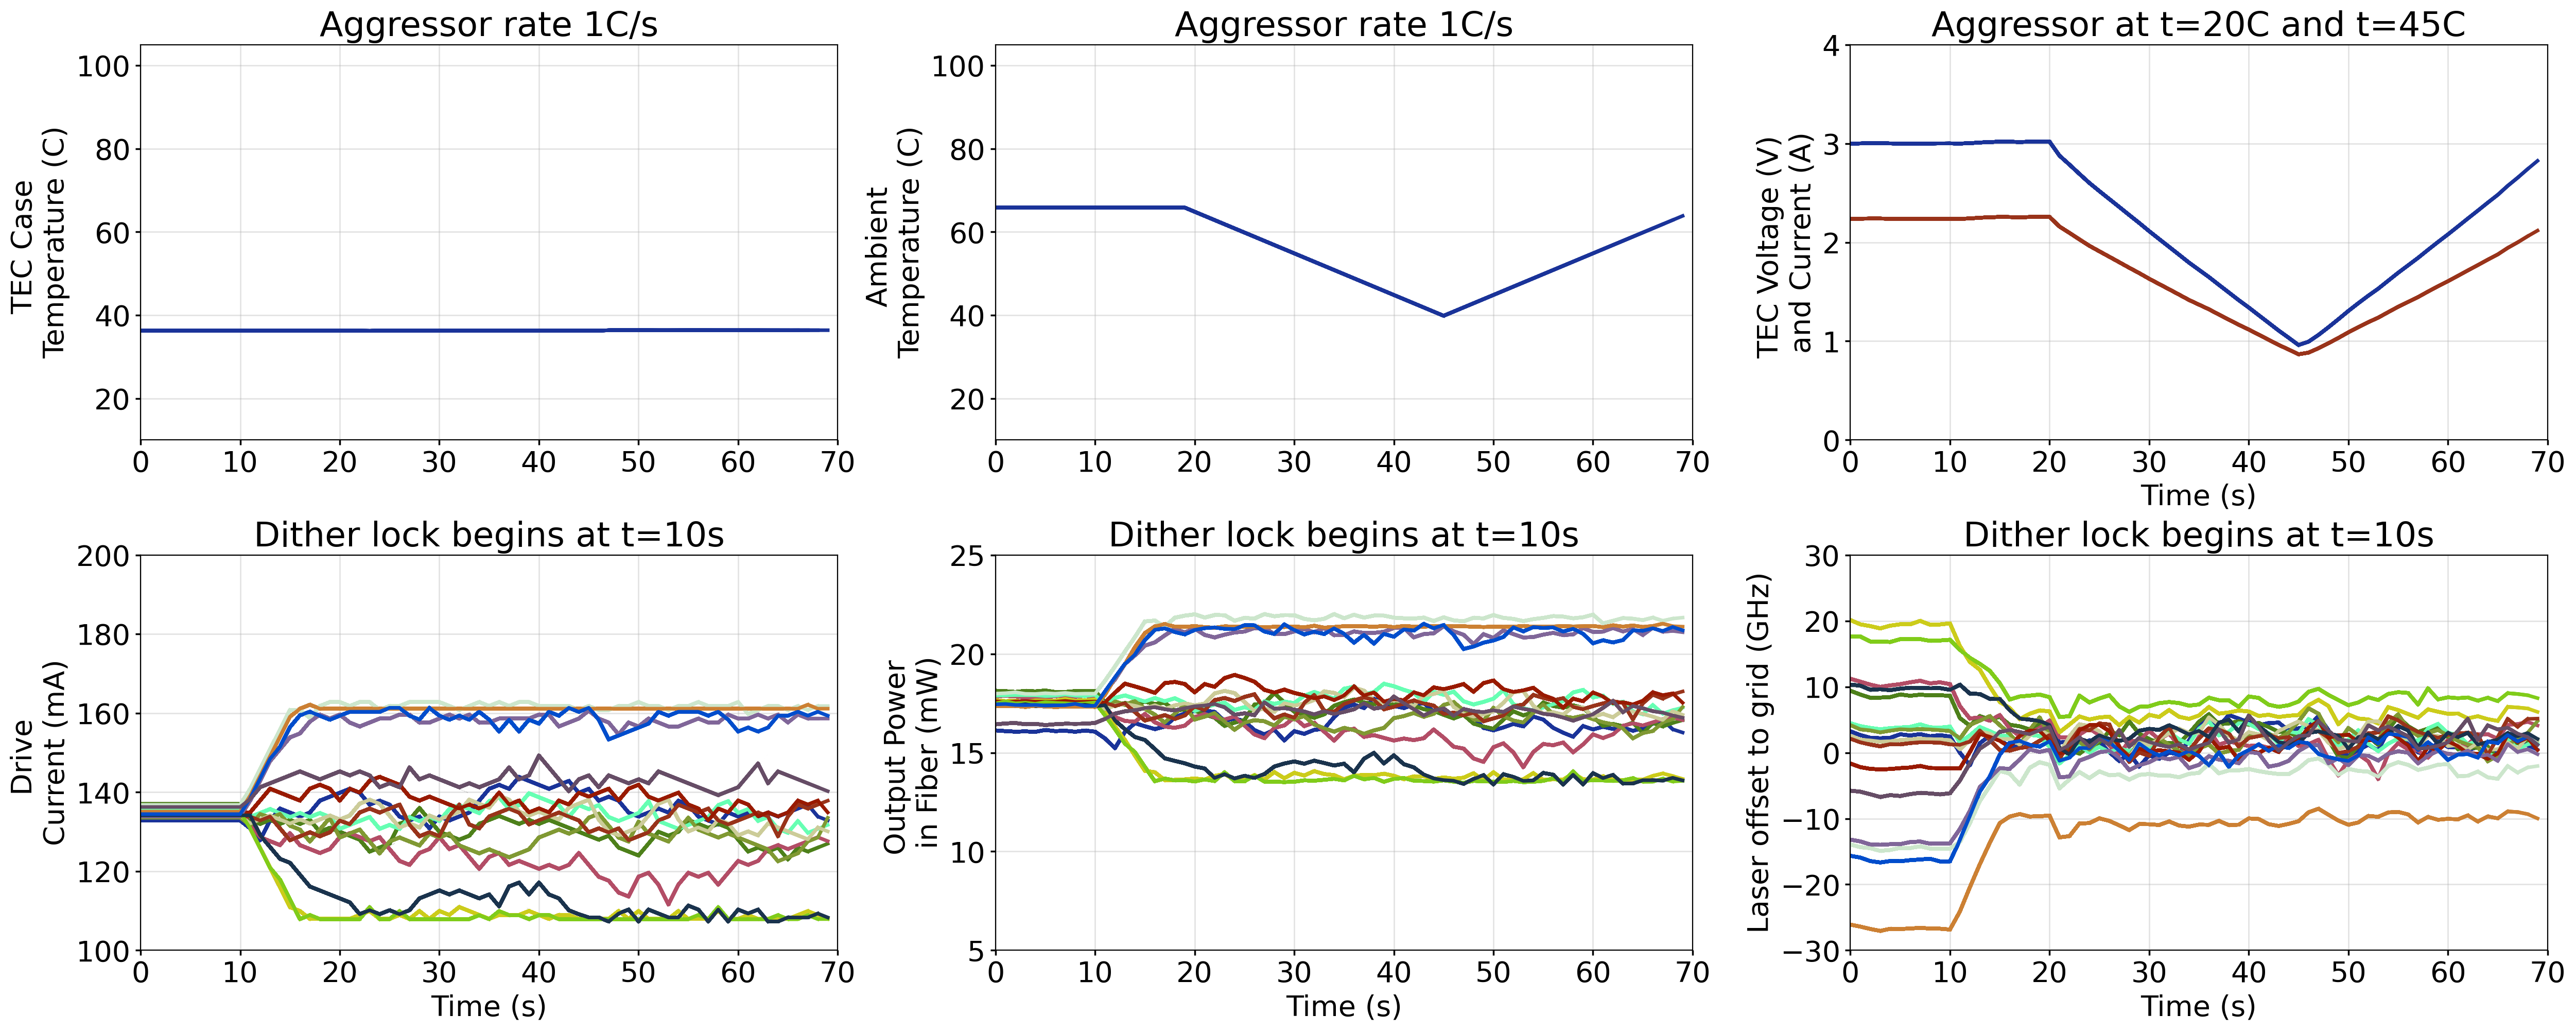

In [16]:
Writer = writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(25, 10))
def animation_function(i):
  ax = plt.subplot(231)
  ax.plot(t_reduced[:i]-30, temperature_aggressor_reduced.T[0,:i], linewidth=2.5, color=[r[0], g[0], b[0]])
  ax.set_xlim(xlim)
  ax.set_ylim([10, 105])
  ax.set_ylabel("TEC Case \nTemperature (C)")
  # ax.set_xlabel("Time (s)")
  ax.set_title('Aggressor rate 1C/s')
  
  ax = plt.subplot(232)
  ax.plot(t_reduced[:i]-30, tec_th_reduced.T[0,:i], linewidth=2.5, color=[r[0], g[0], b[0]])
  ax.set_ylim([10, 105])
  ax.set_xlim(xlim)
  ax.set_ylabel("Ambient \nTemperature (C)")
  # ax.set_xlabel("Time (s)")
  ax.set_title('Aggressor rate 1C/s')
  
  ax = plt.subplot(233)
  ax.plot(t_reduced[:i]-30, tec_v_reduced.T[0,:i], linewidth=2.5, color=[r[0], g[0], b[0]])#, label='TEC Voltage (V)')
  ax.plot(t_reduced[:i]-30, tec_i_reduced.T[0,:i], linewidth=2.5, color=[r[8], g[8], b[8]])#, label = 'TEC Current (A)')
  ax.set_ylabel("TEC Voltage (V) \nand Current (A)")
  ax.set_xlim(xlim)
  ax.set_xlabel("Time (s)")
  ax.set_ylim([0, 4])
  ax.set_title('Aggressor at t=20C and t=45C')
  
  ax = plt.subplot(234)
  for idd in range(16):
    ax.plot(t_reduced[:i]-30, laser_drive_current_array_reduced.T[idd,:i]*1e3, linewidth=2.5, color=[r[idd], g[idd], b[idd]])
  ax.set_ylabel("Drive \nCurrent (mA)")
  ax.set_ylim([100, 200])
  ax.set_xlim(xlim)
  ax.set_xlabel("Time (s)")
  ax.set_title('Dither lock begins at t=10s')
  
  ax=plt.subplot(235)
  for idd in range(16):
    ax.plot(t_reduced[:i]-30, output_power_array_reduced.T[idd,:i]*1e3, linewidth=2.5, color=[r[idd], g[idd], b[idd]])
  ax.set_ylabel("Output Power \nin Fiber (mW)")
  ax.set_ylim([5, 25])
  ax.set_xlim(xlim)
  ax.set_xlabel("Time (s)")
  ax.set_title('Dither lock begins at t=10s')
  
  ax=plt.subplot(236)
  for idd in range(16):
    ax.plot(t_reduced[:i]-30, wavelength_error_reduced.T[idd,:i]*1e9/0.1*17, linewidth=2.5, color=[r[idd], g[idd], b[idd]])
  ax.set_ylabel("Laser offset to grid (GHz)")
  ax.set_ylim([-30, 30])
  ax.set_xlim(xlim)
  ax.set_xlabel("Time (s)")
  ax.set_title('Dither lock begins at t=10s')
  fig.tight_layout()

animation = FuncAnimation(fig, animation_function, frames=len(t_reduced), interval=10)
animation.save('sppd_laser_clm_lock_1cps.mp4', writer=writer)